# TGFB2
[Loeys-Dietz syndrome-4 (LDS4)](https://omim.org/entry/614816) is caused by heterozygous mutation in the TGFB2 gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.6.dev0


### TGFB2
We use the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TGFB2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'TGFB2'
mane_tx_id = 'NM_003238.6'
mane_protein_id = 'NP_003229.1' 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 36/36 [00:01<00:00, 22.75 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
23,Aortic root aneurysm
21,High palate
20,Pes planus
18,Joint hypermobility
18,Inguinal hernia
17,Arachnodactyly
16,Abnormal sternum morphology
14,Retrognathia
13,Striae distensae
11,Tall stature


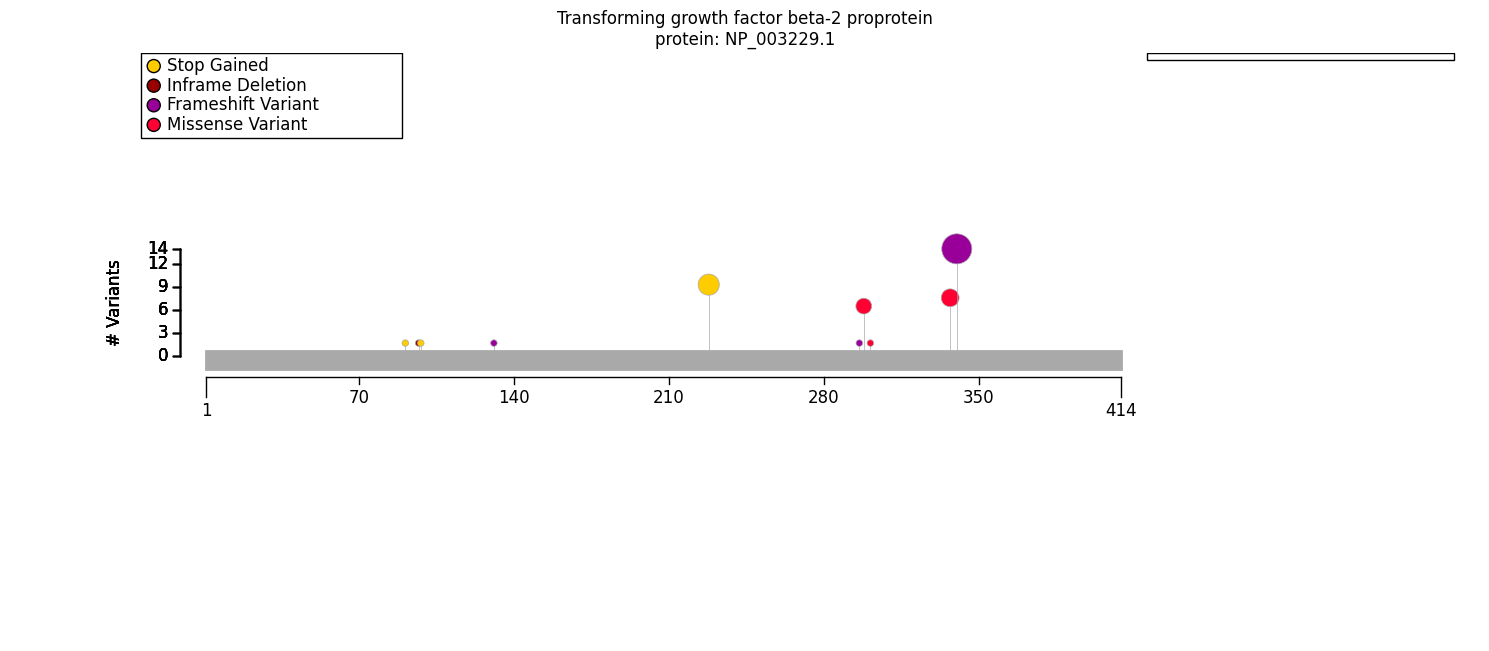

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

tgfb2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
tgfb2_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="missense", 
    b_label="other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,8
Skipping term because one genotype had zero observations,1
"Skipping ""general"" level terms",53
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),110


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense,other,Corrected p values,p values
Retrognathia [HP:0000278],7/8 (88%),7/21 (33%),0.525137,0.014193
Inguinal hernia [HP:0000023],7/8 (88%),11/26 (42%),0.786345,0.042505
Mitral valve prolapse [HP:0001634],3/4 (75%),6/24 (25%),0.844391,0.084103
Downslanted palpebral fissures [HP:0000494],5/8 (62%),5/20 (25%),0.844391,0.091286
Bicuspid aortic valve [HP:0001647],0/8 (0%),2/7 (29%),1.000000,0.200000
High palate [HP:0000218],7/8 (88%),14/24 (58%),1.000000,0.209268
Aortic dissection [HP:0002647],1/8 (12%),3/7 (43%),1.000000,0.282051
Striae distensae [HP:0001065],2/8 (25%),11/24 (46%),1.000000,0.420349
Spondylolisthesis [HP:0003302],0/8 (0%),2/14 (14%),1.000000,0.515152
Hypertelorism [HP:0000316],1/8 (12%),5/21 (24%),1.000000,0.647215


In [9]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Joint hypermobility [HP:0001382],7/8 (88%),11/23 (48%),1.0,0.095350
Scoliosis [HP:0002650],5/9 (56%),6/23 (26%),1.0,0.213366
Pneumothorax [HP:0002107],1/4 (25%),0/13 (0%),1.0,0.235294
Striae distensae [HP:0001065],2/9 (22%),11/23 (48%),1.0,0.249088
Tall stature [HP:0000098],1/4 (25%),11/18 (61%),1.0,0.293233
Hypertelorism [HP:0000316],3/8 (38%),3/21 (14%),1.0,0.304509
Pectus excavatum [HP:0000767],1/5 (20%),0/11 (0%),1.0,0.312500
Arachnodactyly [HP:0001166],6/8 (75%),11/21 (52%),1.0,0.408347
Spondylolisthesis [HP:0003302],1/5 (20%),1/17 (6%),1.0,0.411255
High palate [HP:0000218],7/9 (78%),14/23 (61%),1.0,0.441376


# Summary

In [10]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "No significant association found."

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [11]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,37,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,38,0


In [12]:
summarizer.process_latex(report=report, protein_fig=tgfb2_fig)

Figure saved to ../../supplement/img/TGFB2_protein_diagram-draft.pdf
Output to ../../supplement/tex/TGFB2_summary_draft.tex
